In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import tqdm.notebook
import sycomore
from sycomore.units import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# PCASL: A typical real sequence may use 750 0.5 ms, 20◦, Hann RF pulses over a 1500 ms period
labelling_length = 275*ms # ms
pld = 2000*ms
flip_angle = 5*deg
DeltaT = 0.2*ms
gamma = 42.6e6 * Hz/T # Hz/T
Gamma = gamma * 2 * np.pi * rad # rads/Ts
B1_per_pulse = flip_angle / (Gamma * DeltaT)

dt = 0.1*ms
T1 = 1650*ms # [Zhang et al.]
T2 = 180*ms
zero = 0*mT/m
G_label = 5*mT/m
G_grase = 40*mT/m
spoil = 400*mT/m
TE = 50*ms
delta = 5*ms
blip = delta ** 2 / TE

r = np.linspace(-0.1, 0.1, 20) * mm
xx, yy = np.meshgrid(r, r)
flow_voxel = np.zeros(xx.shape + (int(round((labelling_length + pld + 3 * TE) / dt + 4)),3))
static_voxel = np.zeros(xx.shape + (int(round((labelling_length + pld + 3 * TE) / dt + 4)),3))
control_flow_voxel = np.zeros(xx.shape + (int(round((labelling_length + pld + 3 * TE) / dt + 4)),3))

In [3]:
# In grey matter in the brain, perfusion replaces about 1% of the brain water with new blood water 
# flowing in every second, so a typical 2 s ASL bolus can only perturb 
# at most 2% of the magnetization in a typical brain voxel [4]

# [4] D. C. Alsop, J. A. Detre, X. Golay, M. Günther, J. Hendrikse, L. Hernandez- Garcia, H. Lu, B. J. MacIntosh, L. M. Parkes, M. Smits, M. J. P. van Osch, D. J. J. Wang, E. C. Wong, and G. Zaharchuk, “Recommended implementa- tion of arterial spin-labeled perfusion MRI for clinical applications: A con- sensus of the ISMRM perfusion study group and the european consortium for ASL in dementia,” Magnetic Resonance in Medicine, vol. 73, pp. 102–116, Apr. 2014.

labelled_fraction = 0.02
static_spins = xx.size * (1 - labelled_fraction) / labelled_fraction

In [4]:
flowrate = 0.005 # cm/ms
flowffset = 1.25 # cm
def trajectory(t):
    """
    Return position in cm given time in ms.
    """
    r = flowrate * t - flowffset
    return r

In [5]:
trajectory(0), trajectory(labelling_length.convert_to(ms))

(-1.25, 0.125)

In [6]:
aliased_labelling_plane = (1 / (gamma * G_label * DeltaT)).convert_to(cm)
aliased_labelling_plane

2.3474178403755865

## Bloch Simulations

### Tagging Sequence

In [7]:
# Static spins
species = sycomore.Species(T1, T2)

pbar = tqdm.notebook.tqdm(total=xx.size)
for xind, x in enumerate(r):
    for yind, y in enumerate(r):
        pbar.update()
        
        position = [x, y + trajectory(labelling_length.convert_to(ms)) * cm] # loop to sim full isochromat within a voxel -> can see echo and spoiler

        idle = sycomore.bloch.time_interval(species, dt)
        pulse_90 = sycomore.bloch.pulse(90*deg)
        pulse_180 = sycomore.bloch.pulse(180*deg)

        ## Waiting
        
        t = 0*s
        M = np.array([0,0,1,1])
        record = [[t, M[:3]/M[3]]]
                
        length = labelling_length + pld
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])
        
        ## Acquisition
        
        gradient_both = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[G_grase, G_grase], position=position)
        gradient_x = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[G_grase, zero], position=position)
        neg_gradient_x = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[-G_grase, zero], position=position)
        gradient_y = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G_grase], position=position)
        neg_gradient_y = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, -G_grase], position=position)
        gradient_y34 = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, -G_grase * 3/4], position=position)
        gradient_y12 = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G_grase / 2], position=position)
        gradient_y58 = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G_grase * 5/8], position=position)
        gradient_y58n = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, -G_grase * 5/8], position=position)        
        spoiler = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[spoil, spoil], position=position)

        M = pulse_90 @ M
        record.append([t, M[:3]/M[3]])

        length = delta / 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])

        length = TE / 2 - delta / 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])    

        M = pulse_180 @ M
        record.append([t, M[:3]/M[3]])
        
        length = TE / 2 - delta * 1.5 - blip * 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]]) 
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y @ M
            record.append([t, M[:3]/M[3]]) 
             
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])     
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y34 @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = neg_gradient_x @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y34 @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])    
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y12 @ M
            record.append([t, M[:3]/M[3]])  
        
        length = TE / 2 - delta * 1.5 - blip * 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]]) 
            
        M = pulse_180 @ M
        record.append([t, M[:3]/M[3]])
            
        length = TE / 2 - delta * 1.5 - blip * 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])   
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y58 @ M
            record.append([t, M[:3]/M[3]]) 
             
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])     
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y58n @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = neg_gradient_x @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y58n @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])    
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y58 @ M
            record.append([t, M[:3]/M[3]])  
        
        length = TE / 2 - delta * 1.5 - blip * 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])     

        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])

        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = spoiler @ M
            record.append([t, M[:3]/M[3]])

        length = delta * 3
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])
        
        time, magnetization = list(zip(*record))
        magnetization = np.array(magnetization)
        static_voxel[xind, yind] = magnetization

  0%|          | 0/400 [00:00<?, ?it/s]

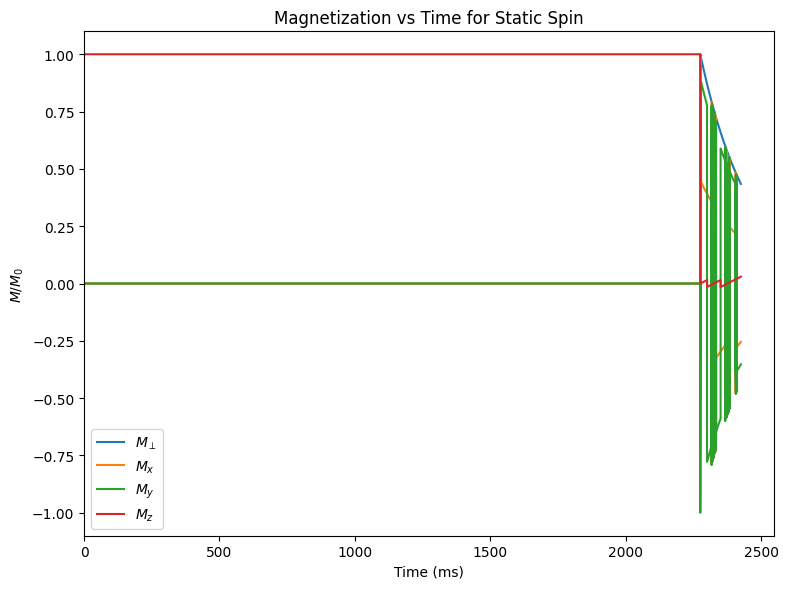

In [8]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(
    x_axis, np.linalg.norm(magnetization[:, :2], axis=-1), label="$M_\perp$")
plt.plot(x_axis, magnetization[:, 0], label="$M_x$")
plt.plot(x_axis, magnetization[:, 1], label="$M_y$")
plt.plot(x_axis, magnetization[:, 2], label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('Magnetization vs Time for Static Spin')
plt.tight_layout()

In [9]:
transverse_mag = (static_voxel[..., 0] + 1j * static_voxel[..., 1]).mean(axis=(0, 1))
longitudinal_mag = static_voxel[..., 2].mean(axis=(0, 1))

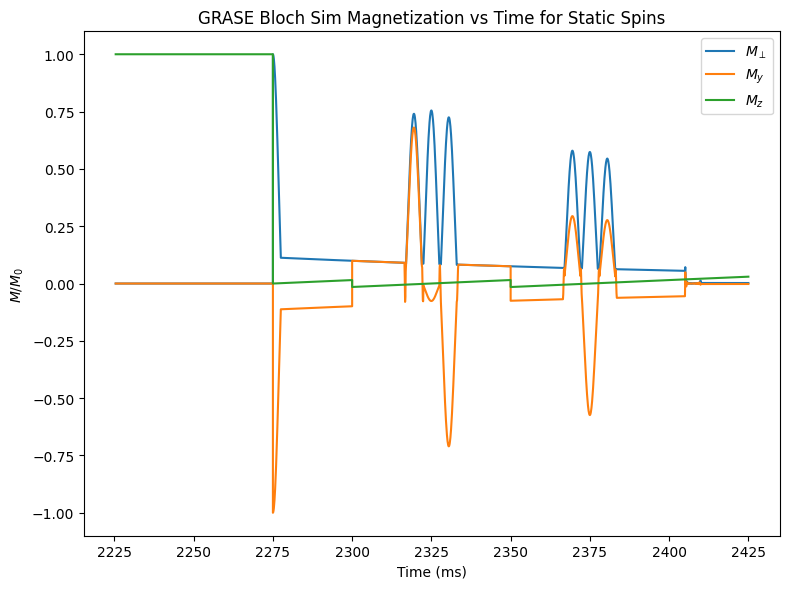

In [10]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis[-2000:], np.abs(transverse_mag[-2000:]), label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
plt.plot(x_axis[-2000:], transverse_mag.imag[-2000:], label="$M_y$")
plt.plot(x_axis[-2000:], longitudinal_mag[-2000:], label="$M_z$")
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('GRASE Bloch Sim Magnetization vs Time for Static Spins')
plt.tight_layout()
plt.savefig('figures/GRASE Bloch Sim Magnetization vs Time for Static Spins.png')

In [11]:
# Flowing spins
species = sycomore.Species(T1, T2)

pbar = tqdm.notebook.tqdm(total=xx.size)
for xind, x in enumerate(r):
    for yind, y in enumerate(r):
        pbar.update()

        idle = sycomore.bloch.time_interval(species, dt)
        pulse_90 = sycomore.bloch.pulse(90*deg)
        pulse_180 = sycomore.bloch.pulse(180*deg)
        pulse_label = sycomore.bloch.pulse(flip_angle)

        ## Labelling
        
        t = 0*s
        M = np.array([0,0,1,1])

        record = [[t, M[:3]/M[3]]]
        
        for i in range(int(round(labelling_length / DeltaT))):
            M = pulse_label @ M
            # record.append([t, M[:3]/M[3]])

            length = DeltaT
            for _ in range(int(round(length / dt))):
                t = t+dt
                position = [x, y + trajectory(t.convert_to(ms)) * cm] # loop to sim full isochromat within a voxel -> can see echo and spoiler
                grad = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G_label], position=position)
                M = grad @ M
                record.append([t, M[:3]/M[3]])

        ## Post Label Delay
                
        length = pld
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])
        
        ## Acquisition

        gradient_both = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[G_grase, G_grase], position=position)
        gradient_x = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[G_grase, zero], position=position)
        neg_gradient_x = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[-G_grase, zero], position=position)
        gradient_y = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G_grase], position=position)
        neg_gradient_y = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, -G_grase], position=position)
        gradient_y34 = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, -G_grase * 3/4], position=position)
        gradient_y12 = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G_grase / 2], position=position)
        gradient_y58 = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G_grase * 5/8], position=position)
        gradient_y58n = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, -G_grase * 5/8], position=position)        
        spoiler = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[spoil, spoil], position=position)

        M = pulse_90 @ M
        record.append([t, M[:3]/M[3]])

        length = delta / 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])

        length = TE / 2 - delta / 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])    

        M = pulse_180 @ M
        record.append([t, M[:3]/M[3]])
        
        length = TE / 2 - delta * 1.5 - blip * 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]]) 
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y @ M
            record.append([t, M[:3]/M[3]]) 
             
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])     
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y34 @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = neg_gradient_x @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y34 @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])    
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y12 @ M
            record.append([t, M[:3]/M[3]])  
        
        length = TE / 2 - delta * 1.5 - blip * 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]]) 
            
        M = pulse_180 @ M
        record.append([t, M[:3]/M[3]])
            
        length = TE / 2 - delta * 1.5 - blip * 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])   
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y58 @ M
            record.append([t, M[:3]/M[3]]) 
             
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])     
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y58n @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = neg_gradient_x @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y58n @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])    
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y58 @ M
            record.append([t, M[:3]/M[3]])  
        
        length = TE / 2 - delta * 1.5 - blip * 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])     

        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])

        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = spoiler @ M
            record.append([t, M[:3]/M[3]])

        length = delta * 3
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])
        
        time, magnetization = list(zip(*record))
        magnetization = np.array(magnetization)
        flow_voxel[xind, yind] = magnetization

  0%|          | 0/400 [00:00<?, ?it/s]

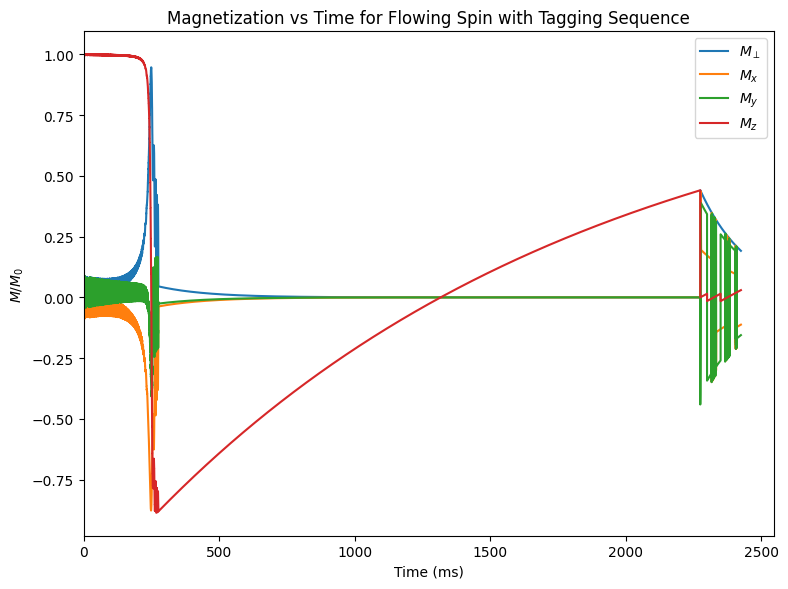

In [12]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(
    x_axis, np.linalg.norm(magnetization[:, :2], axis=-1), label="$M_\perp$")
plt.plot(x_axis, magnetization[:, 0], label="$M_x$")
plt.plot(x_axis, magnetization[:, 1], label="$M_y$")
plt.plot(x_axis, magnetization[:, 2], label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('Magnetization vs Time for Flowing Spin with Tagging Sequence')
plt.tight_layout()

In [13]:
transverse_mag = (flow_voxel[..., 0] + 1j * flow_voxel[..., 1]).mean(axis=(0, 1))
longitudinal_mag = flow_voxel[..., 2].mean(axis=(0, 1))

In [14]:
longitudinal_mag.min()

-0.8433391220121317

In [15]:
x_axis[longitudinal_mag.argmin()] # inversion location in ms

274.89999999998605

In [16]:
x_axis[transverse_mag.imag.argmax()] # echo location in ms

2319.50000000047

In [17]:
(TE + labelling_length + pld - delta).convert_to(ms) # expected echo in ms

2320.0000000000005

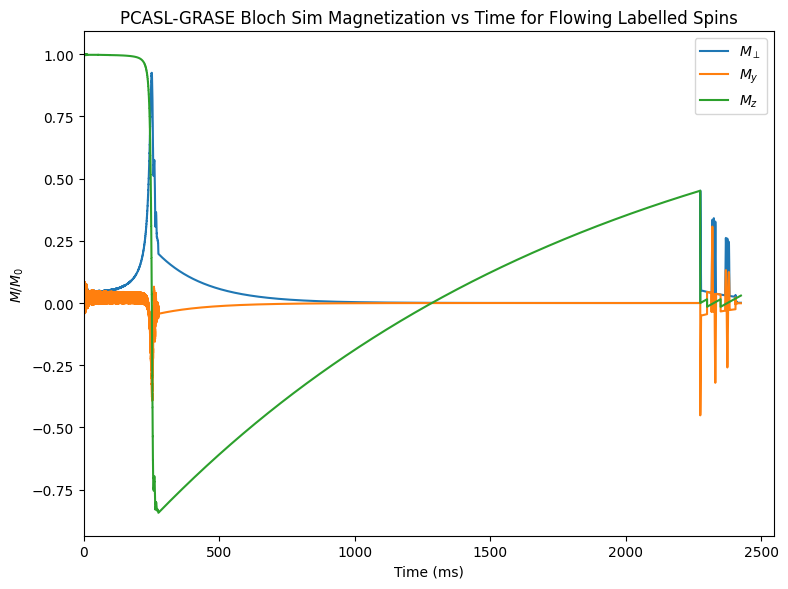

In [18]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis, np.abs(transverse_mag), label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
plt.plot(x_axis, transverse_mag.imag, label="$M_y$")
plt.plot(x_axis, longitudinal_mag, label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('PCASL-GRASE Bloch Sim Magnetization vs Time for Flowing Labelled Spins')
plt.tight_layout()
plt.savefig('figures/PCASL-GRASE Bloch Sim Magnetization vs Time for Flowing Labelled Spins.png')

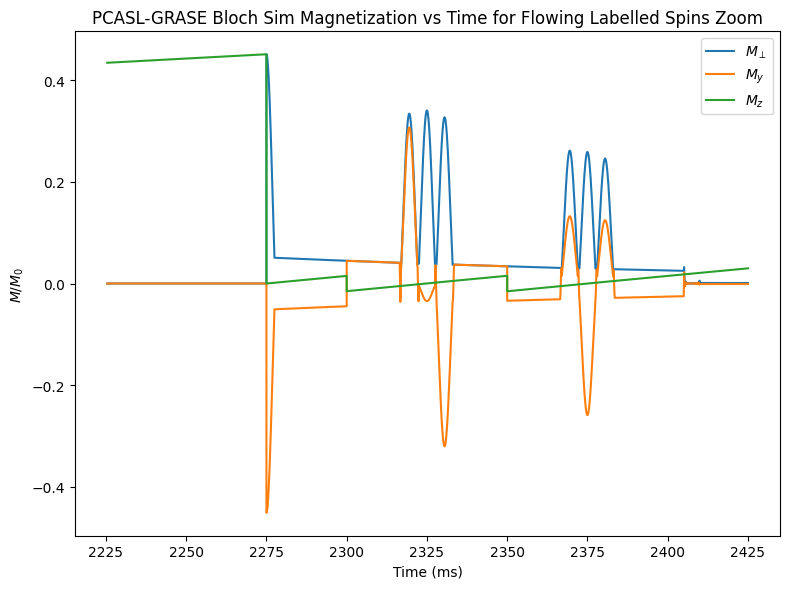

In [19]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis[-2000:], np.abs(transverse_mag[-2000:]), label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
plt.plot(x_axis[-2000:], transverse_mag.imag[-2000:], label="$M_y$")
plt.plot(x_axis[-2000:], longitudinal_mag[-2000:], label="$M_z$")
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('PCASL-GRASE Bloch Sim Magnetization vs Time for Flowing Labelled Spins Zoom')
plt.tight_layout()
plt.savefig('figures/PCASL-GRASE Bloch Sim Magnetization vs Time for Flowing Labelled Spins Zoom.png')

### Combining Static and Flowing Spins

In [20]:
tiled_voxel = static_voxel.repeat(static_spins ** 0.5 / static_voxel.shape[0], axis=0).repeat(static_spins ** 0.5 / static_voxel.shape[1], axis=1).reshape(int(static_spins), -1, 3)
all_spins = np.concatenate([tiled_voxel, flow_voxel.reshape(xx.size, -1, 3)], axis=0)

In [21]:
transverse_mag = (all_spins[..., 0] + 1j * all_spins[..., 1]).mean(axis=0)
longitudinal_mag = all_spins[..., 2].mean(axis=0)

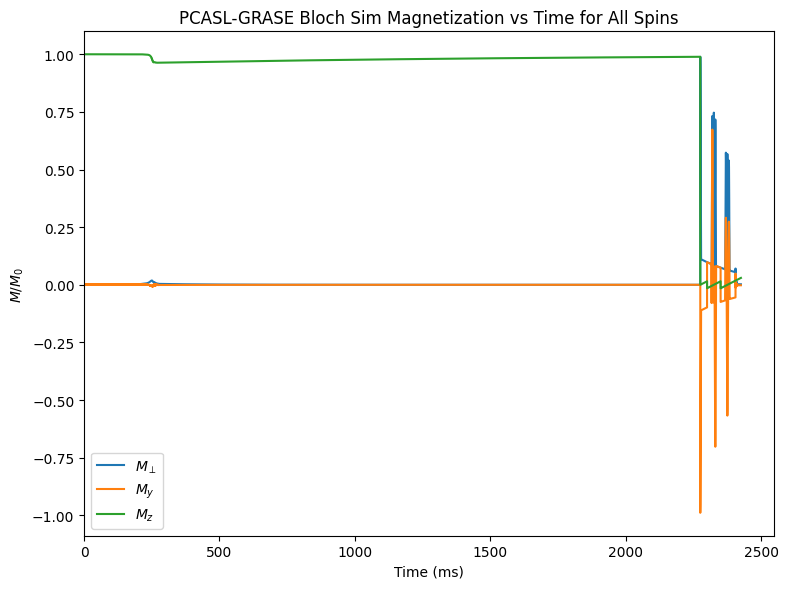

In [22]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis, np.abs(transverse_mag), label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
plt.plot(x_axis, transverse_mag.imag, label="$M_y$")
plt.plot(x_axis, longitudinal_mag, label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('PCASL-GRASE Bloch Sim Magnetization vs Time for All Spins')
plt.tight_layout()
plt.savefig('figures/PCASL-GRASE Bloch Sim Magnetization vs Time for All Spins.png')

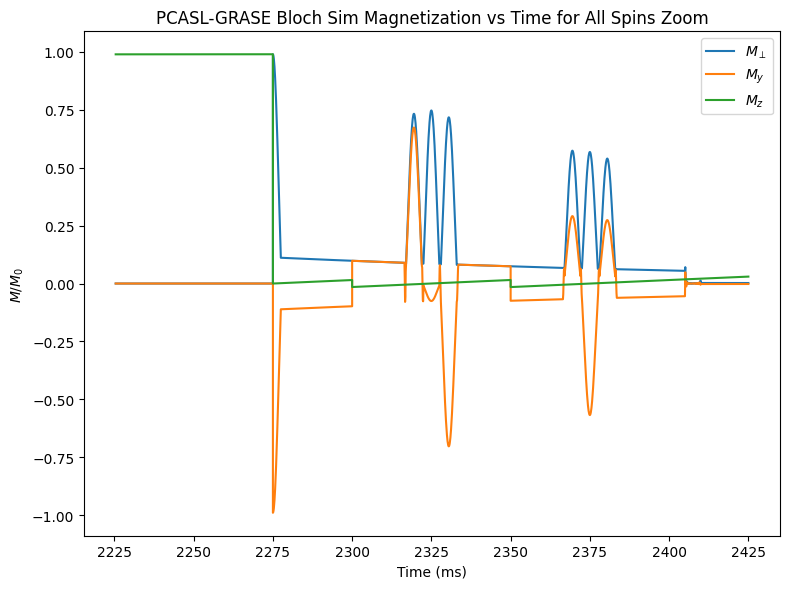

In [23]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis[-2000:], np.abs(transverse_mag[-2000:]), label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
plt.plot(x_axis[-2000:], transverse_mag.imag[-2000:], label="$M_y$")
plt.plot(x_axis[-2000:], longitudinal_mag[-2000:], label="$M_z$")
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('PCASL-GRASE Bloch Sim Magnetization vs Time for All Spins Zoom')
plt.tight_layout()
plt.savefig('figures/PCASL-GRASE Bloch Sim Magnetization vs Time for All Spins Zoom.png')

### Control Sequence

In [24]:
# Flowing spins
species = sycomore.Species(T1, T2)

pbar = tqdm.notebook.tqdm(total=xx.size)
for xind, x in enumerate(r):
    for yind, y in enumerate(r):
        pbar.update()

        idle = sycomore.bloch.time_interval(species, dt)
        pulse_90 = sycomore.bloch.pulse(90*deg)
        pulse_180 = sycomore.bloch.pulse(180*deg)
        pulse_label = sycomore.bloch.pulse(flip_angle)
        neg_pulse_label = sycomore.bloch.pulse(flip_angle, phase=180*deg)

        ## Labelling
        
        t = 0*s
        M = np.array([0,0,1,1])
        record = [[t, M[:3]/M[3]]]
        
        # need to be careful of rounding here - must have the same number of samples in the sequence
        for i in range(int(labelling_length / DeltaT / 2)):
            M = pulse_label @ M

            length = DeltaT
            for _ in range(int(round(length / dt))):
                t = t+dt
                M = idle @ M
                record.append([t, M[:3]/M[3]])

            M = neg_pulse_label @ M

            length = DeltaT
            for _ in range(int(round(length / dt))):
                t = t+dt
                M = idle @ M
                record.append([t, M[:3]/M[3]])

        ## Post Label Delay
                
        length = pld
        for _ in range(int(round(length / dt)) + 2):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])
        
        ## Acquisition

        gradient_both = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[G_grase, G_grase], position=position)
        gradient_x = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[G_grase, zero], position=position)
        neg_gradient_x = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[-G_grase, zero], position=position)
        gradient_y = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G_grase], position=position)
        neg_gradient_y = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, -G_grase], position=position)
        gradient_y34 = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, -G_grase * 3/4], position=position)
        gradient_y12 = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G_grase / 2], position=position)
        gradient_y58 = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G_grase * 5/8], position=position)
        gradient_y58n = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, -G_grase * 5/8], position=position)        
        spoiler = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[spoil, spoil], position=position)

        M = pulse_90 @ M
        record.append([t, M[:3]/M[3]])

        length = delta / 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])

        length = TE / 2 - delta / 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])    

        M = pulse_180 @ M
        record.append([t, M[:3]/M[3]])
        
        length = TE / 2 - delta * 1.5 - blip * 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]]) 
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y @ M
            record.append([t, M[:3]/M[3]]) 
             
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])     
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y34 @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = neg_gradient_x @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y34 @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])    
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y12 @ M
            record.append([t, M[:3]/M[3]])  
        
        length = TE / 2 - delta * 1.5 - blip * 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]]) 
            
        M = pulse_180 @ M
        record.append([t, M[:3]/M[3]])
            
        length = TE / 2 - delta * 1.5 - blip * 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])   
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y58 @ M
            record.append([t, M[:3]/M[3]]) 
             
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])     
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y58n @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = neg_gradient_x @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y58n @ M
            record.append([t, M[:3]/M[3]]) 
        
        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_x @ M
            record.append([t, M[:3]/M[3]])    
            
        length = blip
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = gradient_y58 @ M
            record.append([t, M[:3]/M[3]])  
        
        length = TE / 2 - delta * 1.5 - blip * 2
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])     

        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])

        length = delta
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = spoiler @ M
            record.append([t, M[:3]/M[3]])

        length = delta * 3
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])
        
        time, magnetization = list(zip(*record))
        magnetization = np.array(magnetization)
        control_flow_voxel[xind, yind] = magnetization

  0%|          | 0/400 [00:00<?, ?it/s]

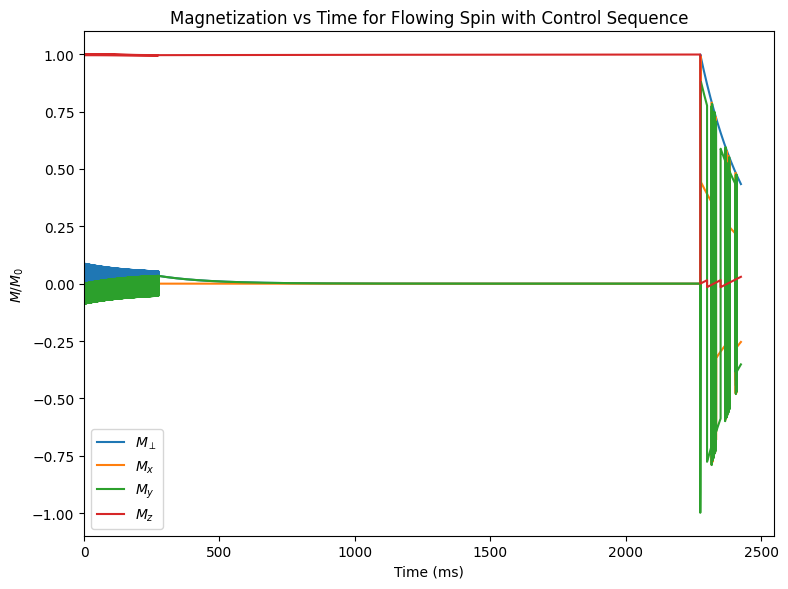

In [25]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(
    x_axis, np.linalg.norm(magnetization[:, :2], axis=-1), label="$M_\perp$")
plt.plot(x_axis, magnetization[:, 0], label="$M_x$")
plt.plot(x_axis, magnetization[:, 1], label="$M_y$")
plt.plot(x_axis, magnetization[:, 2], label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('Magnetization vs Time for Flowing Spin with Control Sequence')
plt.tight_layout()

In [26]:
transverse_mag = (control_flow_voxel[..., 0] + 1j * control_flow_voxel[..., 1]).mean(axis=(0, 1))
longitudinal_mag = control_flow_voxel[..., 2].mean(axis=(0, 1))

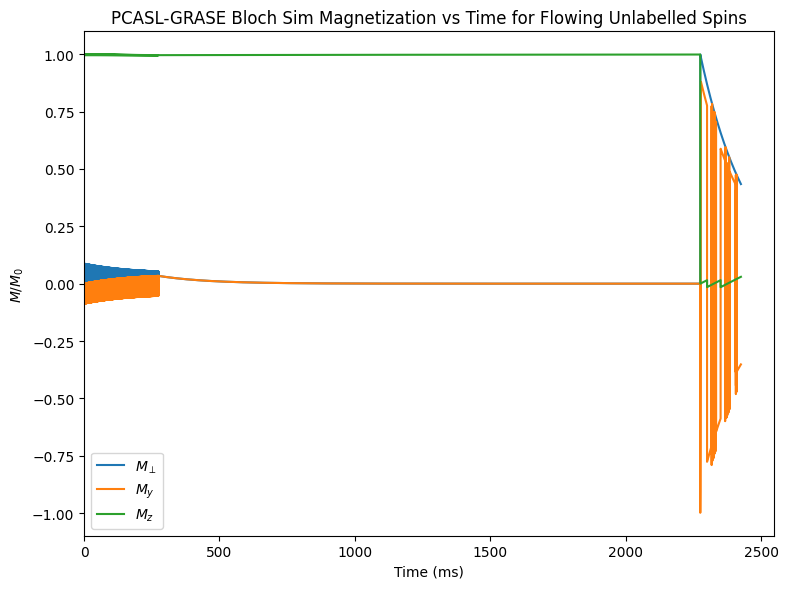

In [27]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis, np.abs(transverse_mag), label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
plt.plot(x_axis, transverse_mag.imag, label="$M_y$")
plt.plot(x_axis, longitudinal_mag, label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('PCASL-GRASE Bloch Sim Magnetization vs Time for Flowing Unlabelled Spins')
plt.tight_layout()
plt.savefig('figures/PCASL-GRASE Bloch Sim Magnetization vs Time for Flowing Unlabelled Spins.png')

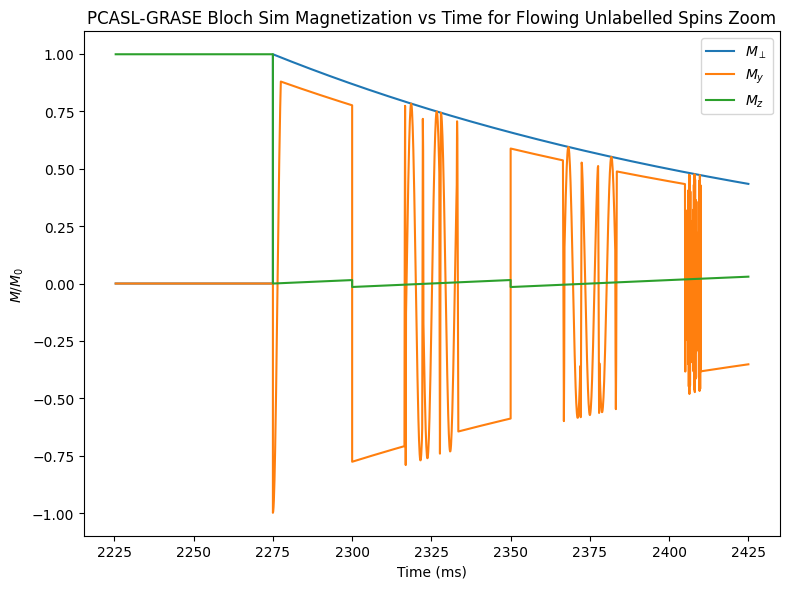

In [28]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis[-2000:], np.abs(transverse_mag[-2000:]), label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
plt.plot(x_axis[-2000:], transverse_mag.imag[-2000:], label="$M_y$")
plt.plot(x_axis[-2000:], longitudinal_mag[-2000:], label="$M_z$")
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('PCASL-GRASE Bloch Sim Magnetization vs Time for Flowing Unlabelled Spins Zoom')
plt.tight_layout()
plt.savefig('figures/PCASL-GRASE Bloch Sim Magnetization vs Time for Flowing Unlabelled Spins Zoom.png')

### Combining Static and Flowing Spins

In [29]:
control_all_spins = np.concatenate([tiled_voxel, control_flow_voxel.reshape(xx.size, -1, 3)], axis=0)

In [30]:
transverse_mag = (control_all_spins[..., 0] + 1j * control_all_spins[..., 1]).mean(axis=0)
longitudinal_mag = control_all_spins[..., 2].mean(axis=0)

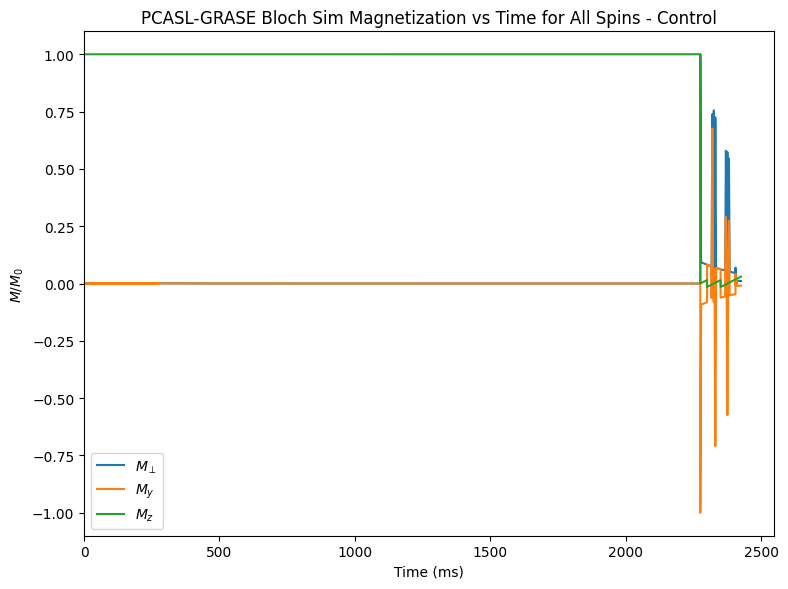

In [31]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis, np.abs(transverse_mag), label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
plt.plot(x_axis, transverse_mag.imag, label="$M_y$")
plt.plot(x_axis, longitudinal_mag, label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('PCASL-GRASE Bloch Sim Magnetization vs Time for All Spins - Control')
plt.tight_layout()
plt.savefig('figures/PCASL-GRASE Bloch Sim Magnetization vs Time for All Spins - Control.png')

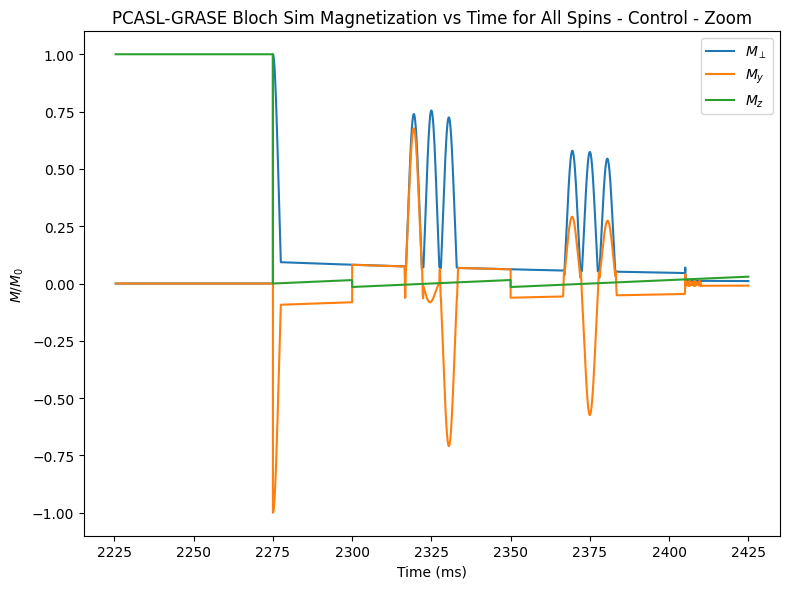

In [32]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis[-2000:], np.abs(transverse_mag[-2000:]), label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
plt.plot(x_axis[-2000:], transverse_mag.imag[-2000:], label="$M_y$")
plt.plot(x_axis[-2000:], longitudinal_mag[-2000:], label="$M_z$")
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('PCASL-GRASE Bloch Sim Magnetization vs Time for All Spins - Control - Zoom')
plt.tight_layout()

## ASL Subtraction

In [33]:
transverse_mag_control = (control_all_spins[..., 0] + 1j * control_all_spins[..., 1]).mean(axis=0)
transverse_mag_tag = (all_spins[..., 0] + 1j * all_spins[..., 1]).mean(axis=0)
transverse_mag = np.abs(transverse_mag_control) - np.abs(transverse_mag_tag)
longitudinal_mag = control_all_spins[..., 2].mean(axis=0) - all_spins[..., 2].mean(axis=0)

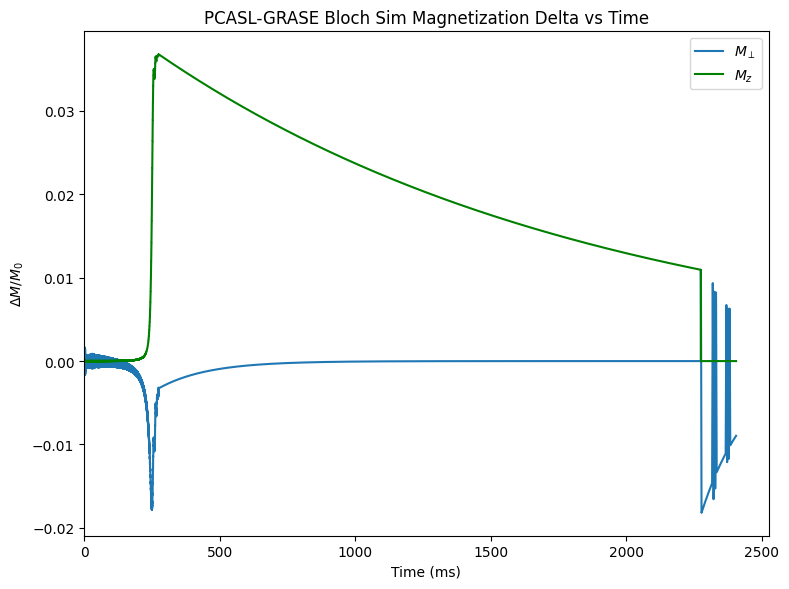

In [43]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis[:-200], transverse_mag[:-200], label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
# plt.plot(x_axis, transverse_mag.imag, label="$M_y$")
plt.plot(x_axis[:-200], longitudinal_mag[:-200], label="$M_z$", color='green')
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$\Delta M/M_0$")
plt.legend()
plt.title('PCASL-GRASE Bloch Sim Magnetization Delta vs Time')
plt.tight_layout()
plt.savefig('figures/PCASL-GRASE Bloch Sim Magnetization Delta vs Time.png')

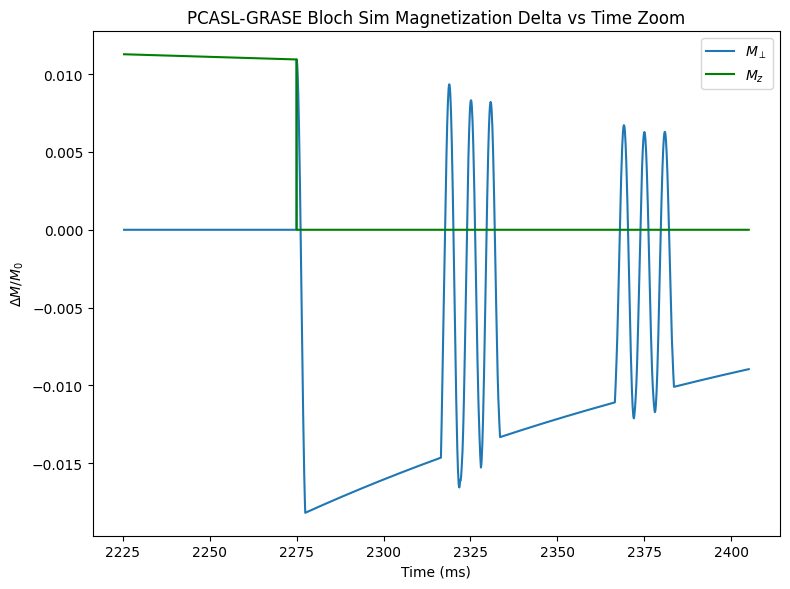

In [44]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis[-2000:-200], transverse_mag[-2000:-200], label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
# plt.plot(x_axis[-2000:], transverse_mag.imag[-2000:], label="$M_y$")
plt.plot(x_axis[-2000:-200], longitudinal_mag[-2000:-200], label="$M_z$", color='green')
plt.xlabel("Time (ms)")
plt.ylabel("$\Delta M/M_0$")
plt.legend()
plt.title('PCASL-GRASE Bloch Sim Magnetization Delta vs Time Zoom')
plt.tight_layout()
plt.savefig('figures/PCASL-GRASE Bloch Sim Magnetization Delta vs Time Zoom.png')